# Minimize a Scalar Function
## or Maximize Volume of a Box

For someone new to optimization, finding the minima or maxima of a simple function is probably one of the first challenges you will face.  Sometimes you can solve them with a bit of calculus.  When that isn't feasible, you can use numerical methods to find a solution.   In this notebook I will investigate the problem of minimizing (or maximizing) a function of one variable (a scalar function). The problem I will use to illustrate this optimization task is maximizing the volume of an open top box cut from a fixed size rectangle.  

 ### The Problem
 Given a sheet of paper that is 8.5 inches by 11 inches, a box will be formed by cutting squares from each corner as shown below.  The box if formed by folding up the resulting four tabs at the dashed fold lines.     
 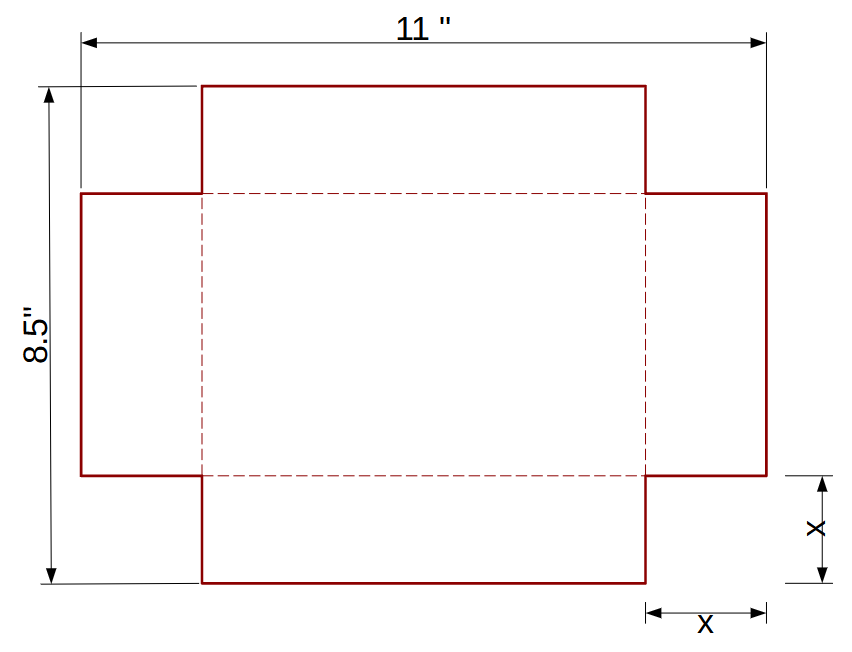
 We want to find the dimension x that will give us the maximum volume for the open top box.  The formula for the box volume is straightforward:  
$$Vol = x(8.5 - 2x)(11 - 2x)$$
We can expand this into a polynomial:   
$$Vol = 93.5 x - 39 x^2 + 4 x^3$$
From looking at the diagram, we can see that x can range from zero to 4.25 inches.  Let's plot this function to see what it looks like.  

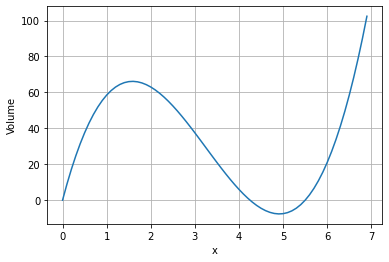

In [22]:
def func(x):
    return 93.5 * x -39 * x**2 + 4 * x**3

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 7, .1)
plt.plot(x, func(x));
plt.xlabel('x')
plt.ylabel('Volume')
plt.grid(True)

We can see a local maximum at around x = 1.5.  We can also see that if we don't constrain x to less than 4.5, we may  get an invalid maximum.  

### Calculus Solution
Since we have a nice polynomial that is easily differentiable, we can apply First Order Necessary Conditons (FONC) and Second Order Conditons (SOC) to find the maxima.  
The FONC is stated as:  $\triangledown f(x^*)=  \frac{\partial f(x^*)}{\partial x_j} = 0,\ \ j=1..n $ &emsp; This is the gradient of the function and a very important concept in mathematical optimization.  In our case, we only have a single variable so the gradient is just the first derivative.   
$$f'(x)= 12 x^2 - 78x + 93.5$$
We can find the roots of this equation with the quadratic formula.  The roots are 4.914 and 1.585.  The second root is looking like a good solution based on our graph above. At this point we know that 4.914 isn't valid since it is outside the range for x but what if we didn't know that?  

The second order condition for a local minimum is stated as: $ \triangledown^2 f(x^*) > 0$ &emsp;  In the general case this is determined by the determinant of the [Hessian](https://en.wikipedia.org/wiki/Hessian_matrix) matrix. For our simple problem the second order condition boils down to $\frac{\mathrm{d^2} }{\mathrm{d} x^2}f(x) > 0$ for a minima and < 0 for a maxima.  
$[24x - 78]_{x=4.914} = 39.9$ which is greater than zero meaning that x=4.914 is a minima.  $[24x - 78]_{x=1.585} = -39.96$ which is less than zero meaning that x=1.585 is a maxima.   

Alas the real world doesn't always present us with problems that have continuous functions that have second order derivatives. In that case we turn to methods that don't require derivatives. 

### Golden Section Search(GSS)
This is a relatively simple yet robust method for finding the local minima of unimodal, univariate functions. Unimodal means the function has one minima or maxima in the range being considered. 

1. Start with a continuous function f(x) that is (hopefully) unimodal over a range [a, b]
2. Compute f(x1) and f(x2) at two intermediate points x1, x2 determined using the [golden ratio](https://en.wikipedia.org/wiki/Golden_ratio).   
3. If f1 > f2, shrink the interval by setting a to x1. Also set x1 = x2 and calculate a new x2 using the golden ratio.   
    If f2 >= f1, shrink the interval by setting b to x2. ALso set x2 = x1 and calculate a new x1 using the golden ratio.  
4. Repeat 2 and 3 until |b-a| <= the convergence tolerance.

There is a nice illustration of this method on [Wikipedia](https://en.wikipedia.org/wiki/Golden-section_search).  

In the following code I multiply the volume function by -1 to turn our maximization problem into a minimization problem. 

In [23]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def golden_section_search(f, a, b, tol=1e-6):
    """
    Perform golden section search to find a local minima point for f(x)
    in interval [a,b]
    If multiple minima are present, it will find a minima but not
    necessarily the global minimum.

    Parameters
    ----------
    f : function
        univariate function f(x).
    a : float
        lower end of range.
    b : float
        upper end of range.
    tol : float, optional
        Convergence tolerance. The default is 1e-6.

    Returns
    -------
    (a+b)/2 : float
        estimate for x at local minima.

    """
    tau = (5**0.5 - 1)/2  # golden ratio - 1
    x1 = a + (1-tau) * (b - a)
    f1 = f(x1)
    x2 = a + tau * (b - a)
    f2 = f(x2)
    i = 0 # counter
    while abs(b-a) > tol:
        i += 1
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + tau * (b - a)
            f2 = f(x2)
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + (1 - tau) * (b-a)
            f1 = f(x1)
            
    return (a + b)/2, i 


def func(x, sign=-1):
    """
    Returns the volume of an open box.
    Since goal is to maximize, I include sign=-1 to convert to a
    function I can minimize. 
    """  
    return sign * x * (8.5 - 2.*x)*(11. - 2.*x)


a = 0
b = 4.25
x, iterations = golden_section_search(func, a, b)
print(f'Golden section search minima: {x:.3f}, {iterations} iterations')

Golden section search minima: 1.585, 32 iterations


GSS works well but requires many iterations to converge on the optimum value.  Perhaps there is a better method.


## Brent's Minimization Method

Richard Brent<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)  came up with a hybrid technique that combines golden section search with successive parabolic interpolation (SPI)<a name="cite_ref-2"></a>[<sup>[1]</sup>](#cite_note-2).   SPI alone will converge faster if the function is well behaved in the interpolation range.  If not, it can diverge.  Brent's method only uses SPI in well behaved ranges.  Otherwise it uses GSS.  
f(x), a and b are the same as for GSS.  SPI uses variables v, w, and x defined as follows:  
given abcissa values a, b, and c in the interval;    
&emsp; x : abscissa value corresponding to the lowest value of f(a), f(b) and f(c).   
&emsp; w : abscissa value corresponding to the second lowest value of f(a), f(b) and f(c).  
&emsp; v : previous value of w (usually abscissa value corresponding to maximum of f(a), f(b) and f(c)).  

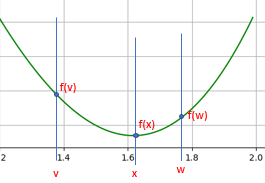


Brent's method follows these steps:
1. Given f(x), an interval [a, b] and a convergence tolerance.
2. Set variables v, w and x to a + C*(b - a).  This is a golden section estimate for $x^*$.
3. Calculate parabolic interpolation factors.
4. If these factors indicate the interpolation is well behaved then predict u (new estimate for $x^*$) with SPI.
5. If not, predict u with GSS.
6. Based on f(u) and f(x), shrink the interval by moving a or b and set v, w and x (using the definitions above).  
7. Repeat steps 3-6 until convergence. 

Since v, w and x are the same for the first cycle, the algorithm will use GSS to predict the next x.  For the second cycle, only one of v, w, x is unique so GSS is again used to predict the next x.  After that, SPI will kick in if the function is well behaved in the interval.  

<a name="cite_note-1"></a>1. [^](#cite_ref-1) "Algorithms for Minimization without Derivatives", Brent, R. P., Prentice-Hall, 1973  
<a name="cite_note-2"></a>2. [^](#cite_ref-2) "An iterative method for locating turning points", Jarratt, P, The Computer Journal, Volume 10, Issue 1, 1967, Pages 82–84.  

In [24]:
import sys

c1 = (5**.5 - 1)/2  # golden_ratio - 1
c2 = (3 - 5**.5)/2  #  2 - golden_ratio

def brents(f, a, b, t=1e-6, verbose=True):
    """
    Brents algorithm for finding minima of scalar function f.
    a and b define the allowable range for x.

    Parameters
    ----------
    f : function
        Pointer to scalar function f(x).
    a : float
        lower bound for x.
    b : float
        upper bound for x.
    t : float
        absolute convergence tolerance

    Returns
    -------
    estimate for x which produces minimum f(x)
    iteration counter

    """
    # intialize
    v = w = x = a + c2 * (b - a)
    e = d = 0.
    i = 0
    eps = sys.float_info.epsilon
    epsi = max(eps * 2, eps**0.5)  # per Brent's guidance
    if verbose:
        print('    a         v        x        w       b       d          tol     meth')
        print('{:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:^10s} {:^10s}  {}'.format(
                a, v, x, w, b, '--', '--', 'start'))

    while True:
        m = (a + b) / 2  # midpoint 
        tol = epsi * abs(x) + t
        
        if (abs(x - m) <= 2 * tol - 0.5 * (b - a)):
            break
        
        i += 1
        p = q = r = 0.0  # initialize
        if abs(e) > tol:
            # parabolic interpolation per Brent's book:
            # p = (x - v)**2 * (f(x) - f(w)) - (x - w)**2 * (f(x) - f(v))
            # q = 2 * ((x - v) * (f(x) - f(w)) - (x - w) * (f(x) - f(v)))
            # Brent's code
            r = (x - w) * (f(x) - f(v))
            q = (x - v) * (f(x) - f(w))
            p = (x - v) * q - (x - w) * r
            q = 2.0 * (q - r)
          
            if (q > 0):
              p = -p
          
            q = abs(q)
            r = e
            e = d

        
        """check for well behaved SPI:
            a <= (x + p/q) <= b and
            abs(p/q) < abs(last_step/2)  """
        if (abs(p) < abs(0.5 * q * r ) and \
                 q * (a - x) < p and \
                 p < q * (b - x)):
            # SPI -- successive parabolic interpolation
            d = p / q
            u = x + d
            #  f must not be evaluated too close to A or B.
            if ((u - a) < 2 * tol or (b - u) < 2 * tol):
                if (x < m):
                  d = tol
                else:
                  d = -tol
            meth = 'spi'

        else:  # GSS - Golden segment search
            m = (a + b) / 2  # midpoint
            if x >= m:
                u = c1*x + c2*a
                e = a - x
            else:
                u = c1*x + c2*b
                e = b - x
            
            d = c2 * e 
            meth = 'gss'
            
        # f must not be evaluated too close to x.
        if (abs(d) >= tol):
            u = x + d
        elif (d > 0):
            u = x + tol
        else:
            u = x - tol

        """
        Update v, x and w to meet the following rules
        x : abscissa for the least value f([x,w,v])   
        w : abscissa for second lowest value f([x,w,v]) 
        v : previous value of w (usually abscissa for greatest value of f([x,w,v]))
        """
        if f(u) <= f(x):
            if u < x:
                b = x
            else:
                a = x
                
            v = w
            w = x
            x = u
            
        else:
            if u < x:
                a = u
            else:
                b = u     
                
            if (f(u) <= f(w) or w == x):
              v = w
              w = u
            elif (f(u) <= f(v) or v == x or v == w ):
              v = u
              
        if verbose:
            print('{:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:10.3e} {:10.3e}  {}'.format(
                a, v, x, w, b, d, tol, meth))
        
    return x, i


x, i = brents(func, 0, 4.25)
print(f'\nBrents solution: {x:8.4f}, {i} iterations')

    a         v        x        w       b       d          tol     meth
  0.0000   1.6234   1.6234   1.6234   4.2500     --         --      start
  0.0000   1.6234   1.6234   2.6266   2.6266  1.003e+00  1.024e-06  gss
  1.0033   2.6266   1.6234   1.0033   2.6266 -6.201e-01  1.024e-06  gss
  1.0033   1.0033   1.6234   1.6509   1.6509  2.752e-02  1.024e-06  spi
  1.0033   1.6509   1.5907   1.6234   1.6234 -3.267e-02  1.024e-06  spi
  1.0033   1.6234   1.5851   1.5907   1.5907 -5.582e-03  1.024e-06  spi
  1.5851   1.5907   1.5854   1.5851   1.5907  2.911e-04  1.024e-06  spi
  1.5854   1.5851   1.5854   1.5854   1.5907  1.902e-05  1.024e-06  spi
  1.5854   1.5854   1.5854   1.5854   1.5907 -1.738e-07  1.024e-06  spi
  1.5854   1.5854   1.5854   1.5854   1.5854  1.024e-06  1.024e-06  spi

Brents solution:   1.5854, 9 iterations


Brent's method finds the maximum in only 9 iterations. The results include the values for a, v, x, w, b, d, tol and meth at the end of each iteration.  As expected, the first 2 iterations use the GSS method then the rest use SPI.  The change in x (d) decreases for each iteration until the last one.  The sequence a, x, b is always in ascending order.  Points v and w move around in the sequence depending on f(w) and f(v). 

### Multi-Modal Functions
If a function has more than one extrema in the search range neither Brent's nor GSS are guaranteed to find the best local minima in the range.

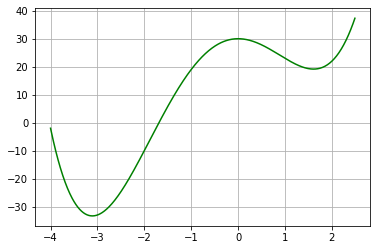

In [17]:
def quartic(x, sign=1):  # a quartic function
    return x**4 + 2*x**3 - 10*x**2 + 30.

a = -4.
b = 2.5

xx = np.arange(a, b, .01)
plt.close('all')
plt.figure(1)
plt.plot(xx, quartic(xx, 1), '-g', label='f(x)' )    
plt.grid(True);

We have two minima in the range.  The one near x = -3 is probably the one we want.  

In [18]:
x, i = brents(quartic, a, b, verbose=False)
print(f"\nBrent's method minima: {x:.4f}, {i} iterations")


Brent's method minima: -3.1085, 12 iterations


So, that's good but what if we use the Scipy implementation of Brent's method?

In [19]:
import scipy.optimize as optimize
result = optimize.minimize_scalar(quartic, bounds=(a, b), method='Brent', tol=1e-6)
print('\nScipy minima (Brent): {:.4f}, {} iterations'.format(result.x, result.nit))


Scipy minima (Brent): 1.6085, 9 iterations


Scipy finds the second minima.  This should not be interpreted as evidence that Scipy's implementation is incorrect or worse than the code above. Instead, this is meant as a warning to choose your range carefully. Always visualize the result.  